## Train Onet on rendered images

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [2]:
args = {
    'config': 'configs/encoder/autoencoder.yaml',
    'no_cuda': True,
    'exit_after': -1
}

In [3]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

/home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
cfg = config.load_config(args["config"], 'configs/default.yaml')
is_cuda = (torch.cuda.is_available() and not args["no_cuda"])
device = torch.device("cuda" if is_cuda else "cpu")

In [5]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
exit_after = args["exit_after"]

In [6]:
model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

In [7]:
# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [8]:
cfg

{'method': 'autoencoder',
 'data': {'dataset': 'Shapes3D',
  'path': 'data/ShapeNet',
  'classes': ['03001627'],
  'input_type': 'img',
  'train_split': 'train',
  'val_split': 'val',
  'test_split': 'test',
  'dim': 3,
  'points_file': 'points.npz',
  'points_iou_file': 'points.npz',
  'points_subsample': 1024,
  'points_unpackbits': True,
  'model_file': 'model.off',
  'watertight_file': 'model_watertight.off',
  'img_folder': 'img_phuc2019',
  'img_size': 224,
  'img_with_camera': False,
  'img_augment': True,
  'img_ext': 'png',
  'bg_augment': 1.0,
  'scale_limit': 0,
  'n_views': 24,
  'pointcloud_file': 'pointcloud.npz',
  'pointcloud_chamfer_file': 'pointcloud.npz',
  'pointcloud_n': 256,
  'pointcloud_target_n': 1024,
  'pointcloud_noise': 0.05,
  'voxels_file': 'model.binvox',
  'with_transforms': False,
  'with_gt': True,
  'bg_folder': 'data/indoor_images'},
 'model': {'decoder': 'simple',
  'encoder': 'aeresnet18',
  'encoder_latent': None,
  'decoder_kwargs': {},
  'encod

In [9]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

### Train

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [11]:
len(train_dataset)

4746

#### Train input

In [12]:
sample = train_dataset[np.random.randint(0, len(train_dataset))]

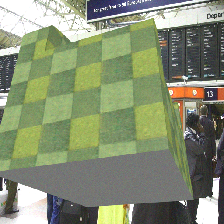

In [13]:
transforms.ToPILImage()(sample['inputs'])

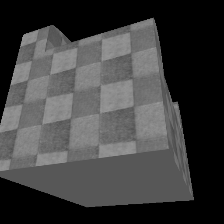

In [14]:
transforms.ToPILImage()(sample['inputs.gt'])

In [15]:
sample.get('inputs.gt').min()

tensor(0.)

### Data loader

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [17]:
batch = next(iter(train_loader))

In [18]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn
)

In [19]:
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn,
)

In [20]:
data = next(iter(vis_loader))

### Model

In [90]:
model = config.get_model(cfg, device=device, dataset=train_dataset)

In [91]:
model

AEResnet18(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [92]:
nparams = sum(p.numel() for p in model.parameters())
print(nparams)

15379072


In [93]:
from torchsummary import torchsummary
torchsummary.summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [94]:
optimizer = config.get_optimizer(model, cfg)

In [95]:
checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)

In [100]:
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

In [101]:
logger.add_graph(model, torch.zeros((1, 3, 224, 224)), verbose=True)

graph(%x : Float(1, 3, 224, 224),
      %1 : Float(64, 3, 7, 7),
      %2 : Float(64),
      %3 : Float(64),
      %4 : Float(64),
      %5 : Float(64),
      %6 : Long(),
      %7 : Float(64, 64, 3, 3),
      %8 : Float(64),
      %9 : Float(64),
      %10 : Float(64),
      %11 : Float(64),
      %12 : Long(),
      %13 : Float(64, 64, 3, 3),
      %14 : Float(64),
      %15 : Float(64),
      %16 : Float(64),
      %17 : Float(64),
      %18 : Long(),
      %19 : Float(64, 64, 3, 3),
      %20 : Float(64),
      %21 : Float(64),
      %22 : Float(64),
      %23 : Float(64),
      %24 : Long(),
      %25 : Float(64, 64, 3, 3),
      %26 : Float(64),
      %27 : Float(64),
      %28 : Float(64),
      %29 : Float(64),
      %30 : Long(),
      %31 : Float(128, 64, 3, 3),
      %32 : Float(128),
      %33 : Float(128),
      %34 : Float(128),
      %35 : Float(128),
      %36 : Long(),
      %37 : Float(128, 128, 3, 3),
      %38 : Float(128),
      %39 : Float(128),
      %40 : Float(

AssertionError: %251 : Float(1, 64, 56, 56) = onnx::Add(%250, %245)
 has empty scope name

In [98]:
trainer = config.get_trainer(model, optimizer, logger, cfg, device=device)

In [99]:
trainer.train_step(batch)

0.3320494294166565

In [35]:
trainer.visualize(data)

100%|██████████| 12/12 [00:00<00:00, 14.59it/s]
